# Policy Evaluation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/riccardoberta/machine-learning/blob/master/05-reinforcement-learning/04-policy-evaluation.ipynb)

Balancing immediate and long-term goals is challenging. We experience this point every day: should I watch movies tonight or keep studying reinforcement learning? The first choice has an immediate satisfaction; the second on the other hand, won’t really give us much tonight, but maybe (and only maybe) will provide much higher satisfaction in the long term. How much more satisfaction in the long term, exactly, we may ask.  I don’t know, you don’t know, and we won’t know unless we try it out, unless we explore it. Life doesn’t give us its MDP! life is uncertain. We need to balance information gathering and information utilization, taking into account the long-term effect and not only the current situation. In this chapter, we’ll study agents that can learn to estimate the value of policies, similar to the policy-evaluation method, but this time without the MDP. 


1. [Reward, return and value function](#Reward,-return-and-value-function)
2. [Improving estimates after each episode: Monte Carlo](#Improving-estimates-after-each-episode)
3. [Improving estimates after each step: Temporal-Difference Learning](#Improving-estimates-after-each-step:-Temporal-Difference-Learning)
4. [Random Walk Enviroment](#Random-Walk-Enviroment)
5. [Batch updating](#Batch-updating)
6. [Improving estimates after multiple steps: n-steps TD](#Improving-estimates-after-multiple-steps:-n-steps-TD)
7. [Improving estimates of all visited states: TD($\lambda$)](#Improving-estimates-of-all-visited-states:-TD)
8. [Exercise](#Exercise)

## Reward, return and value function

The **reward** refers to the one-step signal the agent gets: the agent observes a state, selects an action, and receives a reward signal. The reward signal is the core of RL, but **it is not what the agent is trying to maximize!** Notice that while your agent maximizes the one-step reward, in the long-term, it’s getting less than it could.
The **return** refers to the total discounted rewards. Returns are calculated from any state and usually go until the end of the episode. That is, when a terminal state is reached, the calculation stops. Return tells how much reward the agent obtained in an episode. It is a better indicators of performance, because it contains a long-term sequence, a single-episode history of rewards. But the return **isn’t what an agent tries to maximize**, either! An agent who attempts to obtain the highest possible return may find a policy that takes it through a noisy path; sometimes, this path will provide a high return, but perhaps most of the time a low one.
The **value function** refers to the expectation of returns. We want high returns, but high in expectation (on average). If the agent is in a noisy environment, or if the agent is using a stochastic policy, it’s all fine. The agent **is trying to maximize the expected total discounted reward, after all: value functions**.

## Improving estimates after each episode: Monte Carlo

The goal is to estimate the state-value function $v_{\pi}(s)$ of a policy $\pi$, that is the expectation of returns: 

$\begin{align}
v_{\pi}(s) = E_{\pi}[G_{t:T} | S_t=s]  
\end{align}$

The most straightforward approach that comes to mind is to run several episodes with this policy collecting hundreds of trajectories, and then calculate averages for every state. This method of estimating value functions is called **Monte Carlo prediction (MC)**. It is easy to implement. The agent will first interact with the environment using the policy until the agent hits a terminal state. The collection of state $S_t$, action $A_t$, reward $R_{t+1}$, and next state $S_{t+1}$ is called an **experience tuple**. A sequence of experiences is called a **trajectory**:

$\begin{align}
S_t, A_t, R_{t+1}, S_{t+1}
\end{align}$

$\begin{align}
S_{t+1}, A_{t+1}, R_{t+2}, S_{t+2} 
\end{align}$

$\begin{align}
... 
\end{align}$

$\begin{align}
S_{T-1}, A_{T-1}, R_T, S_T 
\end{align}$

Once we have a trajectory, we can calculate the returns $G_t$ for every state $S_t$ encountered, adding up and discounting the rewards received along the way until the end of the trajectory at time step T: 

$\begin{align}
G_{t:T} = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{T-1}R_T  
\end{align}$

Then, add up the per-state returns and increment a count:

$\begin{align}
T_T(S_t) = T_T(S_t) + G_{t:T}
\end{align}$

$\begin{align}
N_T(S_t) = N_T(S_t) + 1
\end{align}$

Finally, we can estimate the expectation using the empirical mean, so, the estimated state-value function for a state is the mean return for that state:

$\begin{align}
V_T(S_t) = \frac{T_T(S_t)}{N_T({S_t})} 
\end{align}$

As the counts approach infinity, the estimate will approach the true value:

$\begin{align}
N(s) \longrightarrow \infty \Rightarrow V(s) \longrightarrow v_{\pi}(s)
\end{align}$

Notice that means can be calculated incrementally, there’s no need to keep track of the sum of returns for all states. This equation is equivalent and more efficient:

$\begin{align}
V_T(S_t) = V_{T-1}(S_t) + \frac{1}{N_T({S_t})}[G_{t:T} - V_{T-1}(S_t)]
\end{align}$

On this, we can replace the mean for a learning value that can be time dependent or constant:

$\begin{align}
V_T(S_t) = V_{T-1}(S_t) + \alpha_t [G_{t:T} - V_{T-1}(S_t)]
\end{align}$

Where $G_{t:T}$ is the **MC target** and $G_{t:T} - V_{T-1}(S_t)$ is the **MC error**

Notice that V is calculated only at the end of an episode, because the returns depends on it.

<img src="./images/monte-carlo-prediction.png" width="600">

In practice, there are two different ways of implementing the averaging-of returns algorithm. A single trajectory may contain multiple visits to the same state. Should we calculate the returns following each of those visits independently and then include all of those targets in the averages, or should we only use the first visit to each state? Both are valid approaches, and they have similar theoretical properties. The more standard version is **first-visit Monte Carlo (FVMC)**, and its convergence properties are easy to justify. **Every-visit Monte Carlo (EVMC)** is slightly different but has also been proven to converge given infinite samples.

We can implement this methond in Python. First of all, we write a function in order to calculare an exponentially decaying schedule, in order to calculate all the values for alpha for the full process:

In [2]:
import numpy as np

def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    # calculate the number of steps to decay the values, this is the index 
    # where the decaying of values terminates and the min_value continues 
    # until max_steps.
    decay_steps = int(max_steps * decay_ratio)
    
    # the remaining steps (the difference)
    rem_steps = max_steps - decay_steps
    
    # calculare the actual values using the logspace starting from 
    # log_start (default -2) and ending on 0. 
    # The number of values in that space is decay_steps and the base is 
    # log_base (default 10). Notice, the values are reversed 
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    
    # because the values may not end exactly at 0, given it’s the log, 
    # we change them to be between 0 and 1 so that the curve looks smooth and nice.
    values = (values - values.min()) / (values.max() - values.min())
    
    # linear transformation and get points between init_value and min_value
    values = (init_value - min_value) * values + min_value
    
    # just repeats the rightmost value rem_step number of times
    values = np.pad(values, (0, rem_steps), 'edge')
    return values


This hyperparameter is essential. Often, alpha is a positive constant less than 1. Having a constant alpha helps with learning in non-stationary environments. However, we can decay alpha in order to show convergence.

Then we write a function to run a policy over an environment and to extract the collection of experience tuples (called trajectories) for the subsequetn processing:

In [3]:
from itertools import count

def generate_trajectory(pi, env, max_steps=200):
    
    # initialize the done flag and a list of experiences (trajectory)
    done, trajectory = False, []
    
    # looping through until the done flag is set to true
    while not done:
        
        # reset the environment to interact in a new episode
        state = env.reset()
        
         # start counting steps t
        for t in count():
            
            # use the policy function to pick an action
            action = pi(state) 
            
            # step the environment using that action and 
            # obtain the full experience tuple
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)
            
            # append the experience to the trajectory
            trajectory.append(experience)
            
            # if we hit a terminal state break and return
            if done:
                break
                
            # this allows to truncate long trajectories, if desired
            # if the count of steps hits the maximum allowed, 
            # we clear the trajectory, break, and try to obtain another trajectory
            if t >= max_steps - 1:
                trajectory = []
                break
            
            # update the state
            state = next_state
            
    # Finally, we return a NumPy version of
    # the trajectory for easy data manipulation
    return np.array(trajectory, object)

Finally, we write the prediction function that works for first-visit version:

In [4]:
def mc(pi, env, gamma=1.0,
       init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
       n_episodes=500, max_steps=200):
    
    nS = env.observation_space.n
    
    # calculate all discounts at once. 
    discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False)
    
    # calculate all alphas at once
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    
    # initialize the current estimate of the state-value function V
    # and a per-episode copy of V for offline analysis
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    # loop for every episode 
    for e in range(n_episodes):
        
        # generate a trajectory
        trajectory = generate_trajectory(pi, env, max_steps)
        
        # initialize a visits check vector
        visited = np.zeros(nS, dtype=bool)
        
        # now loop through all experiences in the trajectory
        for t, (state, _, reward, _, _) in enumerate(trajectory):
            
            # check if the state has already been visited on 
            # this trajectory (FVMC), if so, we process the next state
            if visited[state]: continue
            visited[state] = True
            
            # calculate the number of steps from t to T
            n_steps = len(trajectory[t:])
            
            # calculate the return
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            
            # estimate the value function
            V[state] = V[state] + alphas[e] * (G - V[state])
        
            # keep track of the episode’s V
            V_track[e] = V
            
    return V.copy(), V_track

## Improving estimates after each step: Temporal-Difference Learning

One of the main drawbacks of Monte Carlo is that the agent has to wait until the end of an episode (when it obtain the return) before it can update the state-value function estimate. 

Moreover, MC has pretty solid convergence properties because it updates the value function estimate using the actual return, which is an unbiased estimate. However, the actual returns are also high-variance estimate as they accumulate many random events in the same trajectory. All actions, all next states, all rewards are random events. The single return collects and compounds all of that randomness for multiple time steps (from t to T). So, the single return $G_{t:T}$ is unbiased, but it has an high variance. All of that randomness becomes noise that can only be alleviated with lots of trajectories.

One way to diminish these issues of high variance and time is to estimate a return instead of waiting for the actual value. Notice that the agent is already calculating the estaimare of the state-value function, so we can use a single-step reward $R_{t+1}$, and once we observe the next state $S_{t+1}$, we can use the state-value function estimates $V(S_{t+1})$ as an estimate of the return at the next step $G_{t+1:T}$. This is the relationship in the equations that **temporal-difference (TD) methods** exploit:

From the return formula, we can rewrite the equation by grouping up some terms:

$\begin{align}
G_{t:T} = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... + \gamma^{T-1} R_T 
\end{align}$

$\begin{align}
= R_{t+1} + \gamma (R_{t+2} + \gamma R_{t+3} + ... + \gamma^{T-2} R_T)  
\end{align}$

$\begin{align}
= R_{t+1} + \gamma G_{t+1:T}   
\end{align}$

Now, the return has a recursive style and we can use this definition to rewrite the state-value function equation:

$\begin{align}
v_{\pi}(s) = E_\pi[G_{t:T} | S_t=s]  
\end{align}$

$\begin{align}
= E_\pi[R_{t+1} + \gamma G_{t+1:T} | S_t=s]  
\end{align}$

$\begin{align}
= E_\pi[R_{t+1} + \gamma v_{\pi}(S_{t+1}) | S_t=s]  
\end{align}$

This means we could estimate the state-value function on every time step:

$\begin{align}
G_{t:t+1} = R_{t+1} + \gamma V_t(S_{t+1})
\end{align}$

$\begin{align}
V_{t+1}(S_t) = V_t(S_t) + \alpha_t [G_{t:t+1} - V_t(S_t)]
\end{align}$

where $R_{t+1} + \gamma V_t(S_{t+1})$ is the **TD target** and $R_{t+1} + \gamma V_t(S_{t+1}) - V_t(S_t)$ is the **TD error**

<img src="./images/td-prediction.png" width="600">

In other words, TD methods estimate $v_\pi(s)$ using an estimate of $v_\pi(s)$. That reward signal $R_{t+1}$ progressively "injects reality" into the estimates. This way of updating an estimate with an estimate is referred to as **bootstrapping**. The TD estimate depends only on a single action, a single transition, and a single reward, so there’s much less randomness being accumulated. As a consequence, TD methods usually learn much faster than MC methods.

It can be seen as a combination of Monte Carlo and dynamic programming ideas. Like Monte Carlo, it learn directly from raw experience without a model of the environment’s dynamics. Like dynamic programming, it update estimates based in part on other learned estimates, without waiting for a final outcome.

This way of updating an estimate with an estimate is referred to as bootstrapping, and it’s much like what the dynamic programming methods we learned about in chapter 3 do. The thing is, though, DP methods bootstrap on the one-step expectation while TD methods bootstrap on a sample of the one-step expectation. That word sample makes a whole lot of a difference.
On the good side, while the new estimated return, the TD target, is a biased estimate of the true state-value function vπ(s), it also has a much lower variance than the actual return Gt:T we use in Monte Carlo updates. This is because the TD target depends only on a single action, a single transition, and a single reward, so there’s much less randomness being accumulated. As a consequence, TD methods usually learn much faster than MC methods.

We can write the temporal-difference algorithm in Python: 

In [5]:
def td(pi, env, gamma=1.0, 
       init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
       n_episodes=500):
    
    nS = env.observation_space.n
    
    # initialize the variables needed
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    # calculate the learning rate schedule for all episodes
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    
    # loop for n_episodes
    for e in range(n_episodes):
        
        # get the initial state and then enter the interaction loop
        state, done = env.reset(), False
        while not done:
            
            # sample the policy pi for the action to take in state
            action = pi(state)
            
            # use the action to interact with the environment... 
            # roll out the policy one step
            next_state, reward, done, _ = env.step(action)
            
            # update V(s)
            td_target = reward + gamma * V[next_state] * (not done)
            td_error = td_target - V[state]
            V[state] = V[state] + alphas[e] * td_error
            
            # update the state variable for the next iteration
            state = next_state
            
        V_track[e] = V
        
    return V, V_track

## Random Walk Enviroment

We ran these policy evaluation algorithms on the **Random Walk (RW) environment**. This is a single-row grid-world environment, with five non-terminal states. The probability of going left when taking the Left action is equal to the probability of going right when taking the Left action, and the probability of going right when taking the Right action is equal to the probability of going left when taking the Right action. In other words, the agent has no con trol of where it goes! The goal is to estimate the expected total discounted reward the agent can obtain given these circumstances. 
It is useful when focusing on the prediction problem, in which there is no need to distinguish the dynamics due to the environment from those due to the agent. 

<img src="./images/random-walk.png" width="600">

In [6]:
class Space:
    def __init__(self, value):
        self.n = value 
    
class RandomWalk:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = Space(7)
        self._state = np.random.choice([1,2,3,4,5])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')
        self._state += np.random.choice([-1, 1])
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 5: self._done = True; reward = 1
        return self._state, reward, self._done, 0  # obs, rew, done

In [7]:
env = RandomWalk()

We evaluate an all-left policy. However the dynamics of the environment make policy being evaluated irrelevant.

In [8]:
def pi(state):
    return 1

We use the same schedule for the learning rate, alpha, in all algorithms: alpha starts at 0.5, and it decreases exponentially to 0.01 in 250 episodes out of the 500 total episodes. In that way alpha helps the algorithms get close to converging, but because alpha don't goes to zero, they don’t fully converge. Other than that, these results should help us gain some intuition about the differences between different methods.

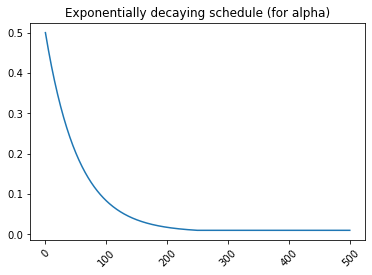

In [9]:
import matplotlib.pyplot as plt
plt.plot(decay_schedule(0.5, 0.01, 0.5, 500))
plt.title('Exponentially decaying schedule (for alpha)')
plt.xticks(rotation=45)
plt.show()

First we can use the Monte Carlo prediction algorith and show the estimates over episodes.

In [10]:
V_mc, V_mc_track = mc(pi, env, n_episodes=500);

In [11]:
print(V_mc)

[0.         0.16663893 0.34319043 0.50922871 0.65938657 0.7954311
 0.        ]


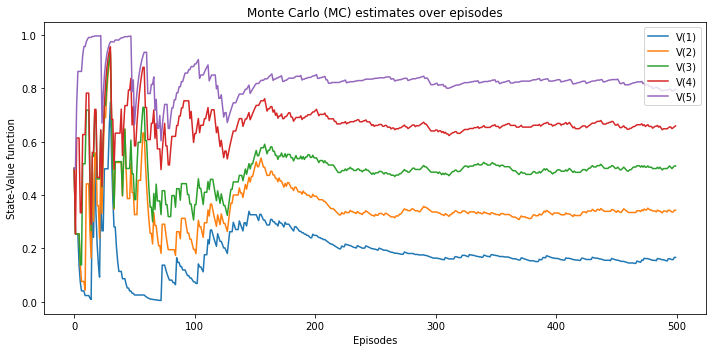

In [12]:
plt.figure(figsize=(10,5))
legends = ['V(1)','V(2)','V(3)','V(4)','V(5)']
plt.plot(V_mc_track[:,1:6])
plt.title('Monte Carlo (MC) estimates over episodes')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()

Now we can use the Temporal-Difference approach:

In [13]:
V_td, V_td_track = td(pi, env, n_episodes=500)

In [14]:
print(V_td)

[0.         0.12990338 0.28950432 0.47918275 0.65121773 0.82303857
 0.        ]


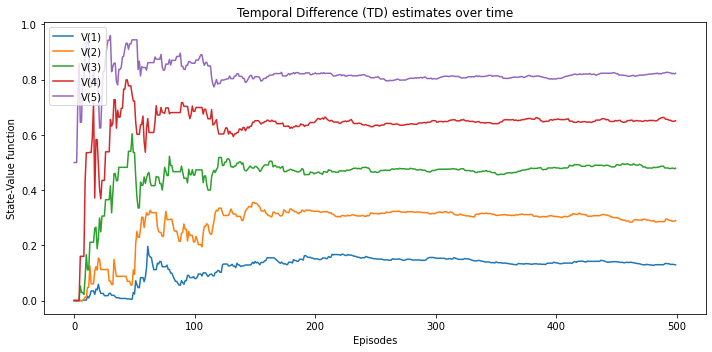

In [15]:
plt.figure(figsize=(10,5))
plt.plot(V_td_track[:,1:6])
plt.title('Temporal Difference (TD) estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()

As you can see in these plots, both algorithms show near-convergence to the true values. Now, see the difference trends: MC running estimates are very noisy; they jump back and forth around the true values, while TD running estimates don’t jump as much, but they are off-center for most of the episodes.

Then we run an experiment to calculate the learning curves for the two methods for and measure the performance using the root mean-squared (RMS) error between the value function learned and the true value function, averaged over the five states, then averaged over 100 runs:

In [16]:
from collections import defaultdict

def run_experiment(algorithm, nb_runs, env, pi,):
    V_init = defaultdict(lambda: 0.5)   # init V to 0.5
    V_init[0] = V_init[6] = 0.0         # but terminal states to zero !!

    V_runs = []
    for i in range(nb_runs):
        _, V_td_track = algorithm(pi,env)
        V_runs.append(V_td_track)
    V_runs = np.array(V_runs) 
    
    V_runs = V_runs[:,:,1:-1]  # remove data about terminal states (which is always zero anyway)
    error_to_true = V_runs - env.V_true[1:-1]
    squared_error = np.power(error_to_true, 2)
    mean_squared_error = np.average(squared_error, axis=-1)  # avg over states
    root_mean_squared_error = np.sqrt(mean_squared_error)
    rmse_avg_over_runs = np.average(root_mean_squared_error, axis=0)
    
    return rmse_avg_over_runs  # this is data that goes directly on the plot

In [17]:
rmse_mc = run_experiment(mc, 100, env, pi)
rmse_td = run_experiment(td, 100, env, pi)

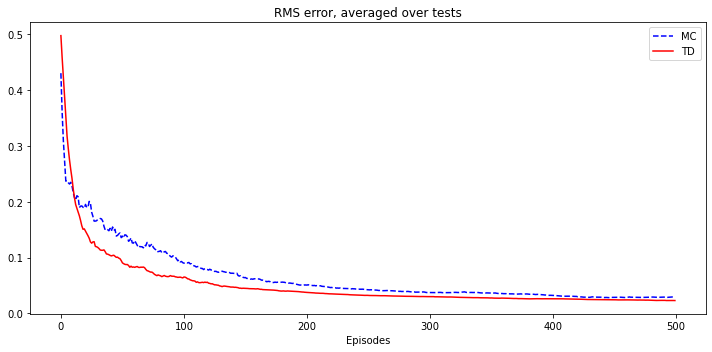

In [18]:
plt.figure(figsize=(10,5))
plt.plot(rmse_mc, color='blue', linestyle='--', label='MC')
plt.plot(rmse_td, color='red', linestyle='-', label='TD')
plt.title('RMS error, averaged over tests')
plt.xlabel('Episodes')
plt.legend()
plt.tight_layout()
plt.show()

The TD method was consistently better than the MC method on this task.

## Batch updating

Suppose there is available only a finite amount of experience. In this case, a common approach is to present the experience repeatedly until the method converges upon an answer. We call this **batch updating** because updates are made only after processing each complete batch of training data.

Under batch updating, TD and MC methods both converge but to different answers. Understanding these two answers will help us understand the difference between the two methods. Suppose we observe the following eight episodes:

A, 0, B, 0 
B, 1
B, 1 
B, 1
B, 1 
B, 1
B, 1 
B, 0

This means that the first episode started in state A, transitioned to B with a reward of 0, and then terminated from B with a reward of 0. The other seven episodes were even shorter, starting from B and terminating immediately. Given this batch of data, what would you say are the optimal predictions, the best values for the estimates V(A) and V(B)? Everyone would probably agree that the optimal value for V(B) is 3/4 , because six out of the eight times in state B the process terminated immediately with a return of 1, and the other two times in B the process terminated immediately with a return of 0. But what is the optimal value for the estimate V(A)? Here there are two reasonable answers. 
One is to observe that all the times the process was in state A it traversed immediately to B; and because we have already decided that B has value 3/4 , therefore A must have value 3/4 as well. This is also the answer that batch TD gives. The other reasonable answer is simply to observe that we have seen A once and the return that followed it was 0; we therefore estimate V(A) as 0. This is the answer that batch MC gives. Notice that it is also the answer that gives minimum squared error on the training data. But still we expect the first answer to be better. If the process is Markov, we expect that the first answer will produce lower error on future data, even though the MC answer is better on the existing data.

This illustrates a general difference between the estimates found by TD and MC methods. Batch MC always find the estimates that **minimize mean-squared error on the training set**, whereas batch TD always finds the **estimates for the model of the Markov process**. In this case, the model is formed from the observed episodes: the estimated transition probability from i to j is the fraction of observed transitions from i that went to j, and the associated expected reward is the average of the rewards observed on those transitions. Given this model, we can compute the estimate of the value function that would be exactly correct if the model were exactly correct. This is called the **certainty-equivalence estimate** because it is equivalent to assuming that the estimate of the underlying process was known with certainty rather than being approximated.

This helps explain why TD method converges more quickly than MC method. Although the non-batch methods do not achieve the certainty-equivalence or the minimum squared-error estimates, they can be understood as moving roughly in these directions. Non-batch TD may be faster than MC because it is moving toward a better estimate, even though it is not getting all the way there.

## Improving estimates after multiple steps: n-steps TD

In MC we sample the environment all the way through the end of the episode before we estimate the value function. On the other hand, in TD the agent interacts with the environment only once, and it estimates the value function. But, is there something in between? TD bootstraps after one step, but how about after two steps? Three? Four? How many steps should we wait before we estimate the expected return and bootstrap on the value function? There’s a spectrum of algorithms lying in between MC and TD. We can tune how much bootstrapping, letting us **balance bias and variance**.

<img src="./images/middle-mc-td.png" width="400">

We have two extremes (MC and TD methods). MC is an **infinite-step method** because it goes all the way until the end of the episode; TD is a **one-step method** because it interacts with the environment for a single step before bootstrapping and updating the state-value function. We can generalize into an **n-step method**. Instead of doing a single step (like TD) or the full episode (like MC), it uses n-steps to calculate value functions. This method is called **n-step TD**.

In n-step TD we have to wait $n$ steps before we can update $V(s)$:

$\begin{align}
S_{t}, A_{t}, R_{t+1}, S_{t+1}, ... ,R_{t+n}, S_{t+n}  
\end{align}$

In reality, the numer of steps can be less then $n$ if the agent reaches a terminal state before, however it could not be more than $n$. Notice that if $n=\infty$ we have MC (where $\infty$ means until the end of the episode) and if $n=1$ we have TD. 

Once we have these $n$ steps, from the return formula, we can rewrite the equation exploiting the information we collect. So instead of:

considering the entire episode (MC):

$\begin{align}
G_{t:T} = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{T-1}R_T  
\end{align}$

$\begin{align}
V_T(S_t) = V_{T-1}(S_t) + \alpha_t [G_{t:T} - V_{T-1}(S_t)]
\end{align}$

considering just one step (TD):

$\begin{align}
G_{t:t+1} = R_{t+1} + \gamma V_t(S_{t+1})
\end{align}$

$\begin{align}
V_{t+1}(S_t) = V_t(S_t) + \alpha_t [G_{t:t+1} - V_t(S_t)]
\end{align}$

we can use $n$ steps:

$\begin{align}
G_{t:t+n} = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{n-1} R_{t+n} + \gamma^{n} V_{t+n-1}(S_{t+n}) 
\end{align}$

$\begin{align}
V_{t+n}(S_t) = V_{t+n-1}(S_t) + \alpha_t [G_{t:t+n} - V_{t+n-1}(S_t)]
\end{align}$

where $G_{t:t+n}$ is the **n-step TD target** and $G_{t:t+n} - V_{t+n-1}(S_t)$ is the **n-step TD error**

When can implement it in Python: 

In [65]:
def generate_path(pi, env, state, n_steps):
    path = []
    done = False
    while len(path) < n_steps:
        action = pi(state) 
        next_state, reward, done, _ = env.step(action)
        experience = (state, action, reward, next_state, done)
        path.append(experience)
        if done: 
            break
        state = next_state
    return np.array(path, object)

In [66]:
def ntd(pi, env, gamma=1.0,
        init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
        n_steps=3, n_episodes=500):
    
    nS = env.observation_space.n
    
    # notice a hybrid between MC and TD: we calculate the discount factors, 
    # but instead of going to max_steps like in MC implementation, 
    # we go to n_step + 1 to include n steps and the bootstrapping estimate
    discounts = np.logspace(0, n_steps+1, num=n_steps+1, base=gamma, endpoint=False)
    
    # calculate all alphas at once
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
      
    # initialize the current estimate of the state-value function V
    # and a per-episode copy of V for offline analysis
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    # loop for every episode 
    for e in range(n_episodes):

        # get the initial state
        state, done = env.reset(), False

        # go collecting a series of n-state paths until we hit done
        while not done:
            # generate a path of n-steps (maximim, or less if we hit done)
            path = generate_path(pi, env, state, n_steps)
            
            # calculate the number of steps, could be ‘n_step’ but it could 
            # also be a smaller if a terminal state is in the path    
            n = len(path)
        
            # initialize a visits check vector
            visited = np.zeros(nS, dtype=bool)
        
            # now loop through all experiences in the path
            for t, (path_state, _, reward, path_next_state, path_done) in enumerate(path):                
                # calculate the partial return
                partial_return = np.sum(discounts[:n-t] * path[t:, 2])
            
                # update the value function
                ntd_target = partial_return + discounts[n] * V[path[n-1, 3]]  * (not path_done)
                ntd_error = ntd_target - V[path_state]
                V[path_state] = V[path_state] + alphas[e] * ntd_error
                                           
                state = path_next_state
                done = path_done
                
        # keep track of the episode’s V
        V_track[e] = V
                      
    return V.copy(), V_track

We can apply this method to the random walk environment:

In [67]:
V_ntd, V_ntd_track = ntd(pi, env, n_steps=3, n_episodes=500)

In [68]:
print(V_ntd)

[0.         0.13834337 0.29834887 0.44245602 0.63269995 0.8359163
 0.        ]


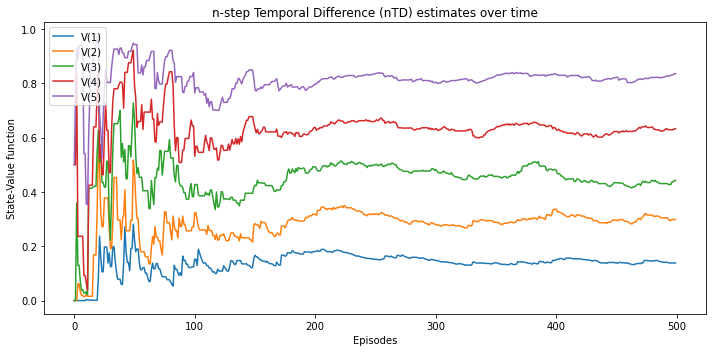

In [69]:
plt.figure(figsize=(10,5))
plt.plot(V_ntd_track[:,1:6])
plt.title('n-step Temporal Difference (nTD) estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()

And we can compare with the TD, MC and nTD (with n_steps=3):

In [70]:
rmse_ntd = run_experiment(ntd, 100, env, pi)

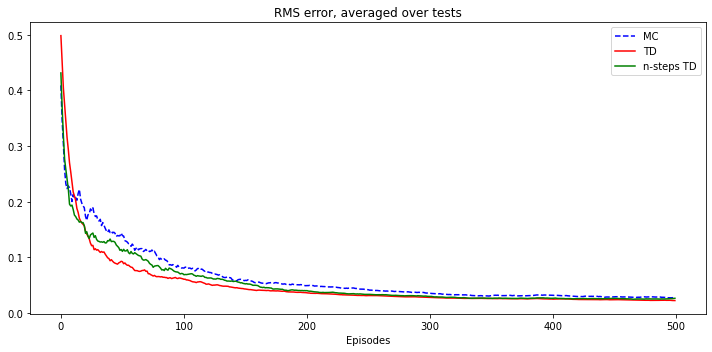

In [71]:
plt.figure(figsize=(10,5))
plt.plot(rmse_mc, color='blue', linestyle='--', label='MC')
plt.plot(rmse_td, color='red', linestyle='-', label='TD')
plt.plot(rmse_ntd, color='green', linestyle='-', label='n-steps TD')
plt.title('RMS error, averaged over tests')
plt.xlabel('Episodes')
plt.legend()
plt.tight_layout()
plt.show()

## Improving estimates of all visited states: TD($\lambda$)

A question emerges: what is a good $n$ value? How about using a weighted combination of all n-step targets as a single target? The agent could go out and calculate the n-step targets corresponding to the one-, two-, three-, ..., infinite-step target, then mix all of these targets with an exponentially decaying factor.  This called **forward-view TD($\lambda$)** method. It combines multiple n-steps into a single update.

We combine all n-step returns until the final step T, and weighting it with an exponentially decaying value:

$\begin{align}
G_{t:t+1} = R_{t+1} + \gamma V_t(S_{t+1})
\end{align}$

$\begin{align}
G_{t:t+n} = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{n-1} R_{t+n} + \gamma^{n} V_{t+n-1}(S_{t+n}) 
\end{align}$

...

$\begin{align}
G_{t:T} = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{T-1}R_T  
\end{align}$

$\begin{align}
\Longrightarrow
\end{align}$

$\begin{align}
G^\lambda_{t:T} = (1 - \lambda)  \sum\limits_{n=1}^{T-t-1}{\lambda^{n-1}G_{t:t+n}} + \lambda^{T-t-1}G_{t:T} 
\end{align}$


In other words, we calculate the one-step return $G_{t:t+1}$ and weight it with the $1-\lambda$ factor, and the two-step return $G_{t:t+2}$ and weight it with $(1-\lambda)\lambda$ factor, and the three-step return $G_{t:t+3}$ and weight it with $(1-\lambda)\lambda^2$ factor, and so on for all n-steps return $G_{t:t+3}$ weighted with $(1-\lambda)\lambda^{n-1}$, until the agent reaches a terminal state, then we get the real return $G_{t:T}$ weighted with $lambda^{T-t-1}$. In the end, we can evaluate the estamate of the value function using this expression of the return:

$\begin{align}
V_T(S_t) = V_{T-1}(S_t) + \alpha_t [G^{\lambda}_{t:T} - V_{T-1}(S_t)]
\end{align}$

where $G^{\lambda}_{t:T}$ is the **TD($\lambda$) target** and $G^{\lambda}_{t:T} - V_{T-1}(S_t)$ is the **TD($\lambda$) error**

<img src="./images/lambda-td.png" width="600">

MC method is under "the curse of the time step" because ita can only apply updates to the state-value function estimates after reaching a terminal state. With n-step bootstrapping, we are still under "the curse of the time step" because we still have to wait until n interacvtions with the environment have passed. With forward-view TD($\lambda$)), we must also wait until the end of an episode before it can apply the corresponding update to the state-value function estimates. But we gain something, we can tune the bias/variance trade-off.

Another method, called, **backward-view TD($\lambda$)**, can split the updates into partial updates and apply those partial updates to the state-value function estimates on every step. This mechanism is called **eligibility traces**. An eligibility trace is a vector that keeps track of recently visited states. The basic idea is to track states that are eligible for an update on every step by how much, so that the corresponding update is applied correctly. 

At the begging of every new episode, we set the eligibility vector to zero:

$\begin{align}
E_0 = 0
\end{align}$

then, we interact with the environment one cycle

$\begin{align}
S_{t}, A_{t}, R_{t+1}, S_{t+1}  
\end{align}$

and when we encounter a state $S_t$, we add a one to its trace in order to mek it eligible for an update 

$\begin{align}
E_t(S_t) = E_t(S_t) + 1
\end{align}$

we then calculate the TD error just as we’ve done so far

$\begin{align}
\delta^{TD}_{t:t+1}(S_t) = R_{t+1} + \gamma V_t(S_{t+1}) - V_t(S_t)
\end{align}$

and we calculate an update to the value function for all states and multiply it by the eligibility trace vector. In this way, only eligible states will get updated

$\begin{align}
V_{t+1} = V_t + \alpha_t \delta^{TD}_{t:t+1}(S_t) E_t
\end{align}$

notice that we are not using a $V_t(S_t)$, but $V_t$ instead, thisi is because we’re multiplying by the eligibility vector, so the eligible states get the corresponding credit. After the update, the eligibility trace vector is decayed, so that future reinforcing events have less impact on earlier states. By doing this, the most recent states get more significant credit for a reward encountered in a recent transition than those states visited earlier in the episode

$\begin{align}
E_{t+1} = \gamma \lambda E_t
\end{align}$

In the following figure we can see the eligibility traces of a four-state environment during a eight-steo episode:

<img src="./images/eligibility-trace.png" width="800">

Notice that TD($\lambda)$ when $\lambda=0$ is equivalent to the TD method, for this reason TD is often referred to as TD(0); on the other hand, TD($\lambda)$, when $\lambda=1$ is equivalent to MC (assuming the updates are accumulated and applied at the end of the episode, otherwise there is a bootstrapping effect) and MS is commonly reffered as TD(1).

We can implement the algorithm in Python:

In [72]:
def td_lambda(pi, env, gamma=1.0,
              init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
              lambda_=0.2, n_episodes=500):
    nS = env.observation_space.n
    
    # initialize the current estimate of the state-value function V
    # and a per-episode copy of V for offline analysis
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    # initialize the eligibility trace vector
    E = np.zeros(nS, dtype=np.float64)
    
    # calculate all alphas at once
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    
    # loop for every episode
    for e in range(n_episodes):
        
        # set E to zero every new episode
        E.fill(0)
        
        # get the initial state
        state, done = env.reset(), False
        
        # get into the time step loop
        while not done:
            
            # sample the policy pi for the action to take in state
            action = pi(state)
            
            # interact with the environment for one step and get the experience tuple
            next_state, reward, done, _ = env.step(action)
            
            # use that experience to calculate the TD error as usual
            td_target = reward + gamma * V[next_state] * (not done)
            td_error = td_target - V[state]
            
            # increment the eligibility of state by 1
            E[state] = E[state] + 1
            
            # apply the error update to all eligible states as indicated by E
            V = V + alphas[e] * td_error * E
            
            # decay E
            E = gamma * lambda_ * E
            
            state = next_state
            
        V_track[e] = V
    return V, V_track

We can apply this method to the random walk environment:

In [73]:
V_td_lambda, V_td_lambda_track = td_lambda(pi, env, lambda_=0.3, n_episodes=500)

In [74]:
print(V_td_lambda)

[0.         0.14529204 0.30712781 0.48324324 0.64952426 0.82517146
 0.        ]


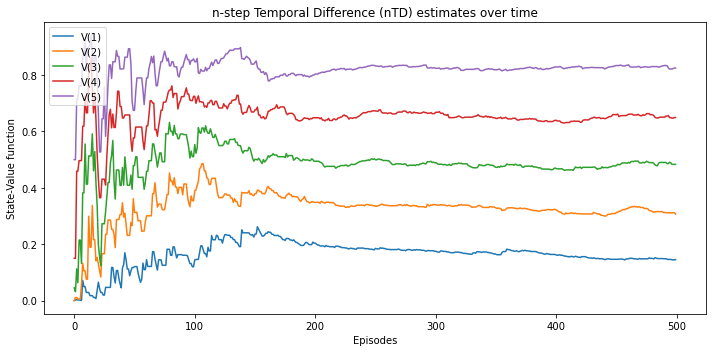

In [75]:
plt.figure(figsize=(10,5))
plt.plot(V_td_lambda_track[:,1:6])
plt.title('TD-lambda estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()

And we can compare with the TD, MC and TD($\lambda$) (with $\lambda=0.2$):

In [76]:
rmse_td_lamda = run_experiment(td_lambda, 100, env, pi)

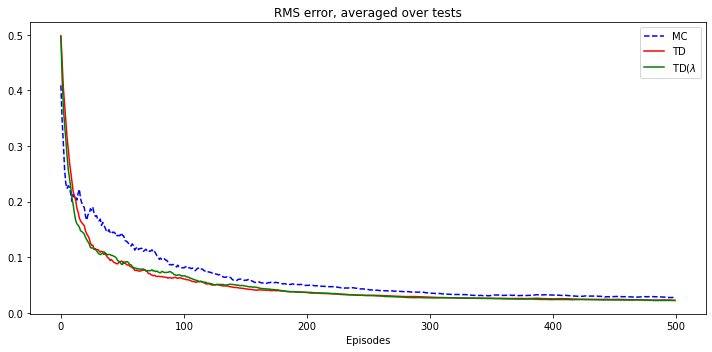

In [77]:
plt.figure(figsize=(10,5))
plt.plot(rmse_mc, color='blue', linestyle='--', label='MC')
plt.plot(rmse_td, color='red', linestyle='-', label='TD')
plt.plot(rmse_td_lamda, color='green', linestyle='-', label='TD($\lambda$)')
plt.title('RMS error, averaged over tests')
plt.xlabel('Episodes')
plt.legend()
plt.tight_layout()
plt.show()

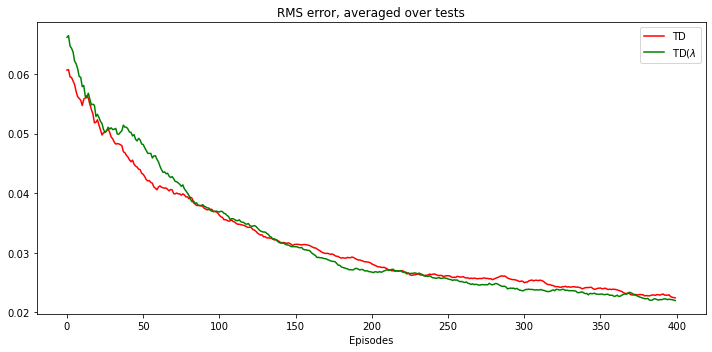

In [78]:
plt.figure(figsize=(10,5))
plt.plot(rmse_td[100:], color='red', linestyle='-', label='TD')
plt.plot(rmse_td_lamda[100:], color='green', linestyle='-', label='TD($\lambda$)')
plt.title('RMS error, averaged over tests')
plt.xlabel('Episodes')
plt.legend()
plt.tight_layout()
plt.show()

## Exercise

**1 - Create the environment from the Russell and Norvig’s book on AI: the Gridworld. This environment is a 3 x 4 grid world in which the agent starts at the bottom-left corner, and it has to reach the top-right corner. There is a hole south of the goal and a wall near the start. The transition function has a 20% noise; that is, 80% the action succeeds, and 20% it fails uniformly at random in orthogonal directions. The reward function is a –0.04 living penalty, a +1 for landing on the goal, and a –1 for landing on the hole.**

<img src="./images/gridworld.png" width="800">

In [79]:
UP, DOWN, LEFT, RIGHT = range(4)

class Space:
    def __init__(self, value):
        self.n = value
        
class GridWorld:
    
    # 0:UP, 1:DOWN, 2:LEFT 3:RIGHT
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = Space(12)
        self.state = 8
        self.columns = 4
        self.rows = 3
        self.done = False
        self.reward = 0
        return self.state
    
    def step(self, action):
        if self.done: raise ValueError('Episode has terminated')
        if action not in [UP, DOWN, LEFT, RIGHT]: raise ValueError('Invalid action')
        
        if action == UP: action = np.random.choice([UP, LEFT, RIGHT], p=[0.8, 0.1, 0.1])
        if action == DOWN: action = np.random.choice([DOWN, LEFT, RIGHT], p=[0.8, 0.1, 0.1])
        if action == LEFT: action = np.random.choice([LEFT, UP, DOWN], p=[0.8, 0.1, 0.1])
        if action == RIGHT: action = np.random.choice([RIGHT, UP, DOWN], p=[0.8, 0.1, 0.1])
        
        row    = self.state // self.columns
        column = self.state % self.columns
        if action == LEFT: column = max(column - 1, 0)
        if action == DOWN: row = min(row + 1, self.rows - 1)
        if action == RIGHT: column = min(column + 1, self.columns - 1)
        if action == UP: row = max(row - 1, 0)
        self.state = row * self.columns + column
        
        self.reward = 0
        if self.state == 3: self.done = True; self.reward = 1
        elif self.state == 5: self.done = True; self.reward = -1   
        
        return self.state, self.reward, self.done, 0


In [80]:
env = GridWorld()

**2 - Write the optimal policy for this environment**

<img src="./images/gridworld-policy.png" width="600">

In [81]:
pi = lambda s: {
    0:RIGHT, 1:RIGHT, 2:RIGHT, 3:LEFT,
    4:UP,    5:LEFT,  6:UP,    7:LEFT,
    8:UP,    9:LEFT, 10:LEFT, 11:LEFT
}[s]

In [84]:
def print_policy(pi, env, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for state in range(env.observation_space.n):
        action = pi(state)
        action_icon = ''
        if action == UP: action_icon = '^'
        if action == DOWN: action_icon = '_'
        if action == LEFT: action_icon = '<-'
        if action == RIGHT: action_icon = '->'
        print('state:', state, '->', 'action:', action_icon)

In [85]:
print_policy(pi, env)

Policy:
state: 0 -> action: ->
state: 1 -> action: ->
state: 2 -> action: ->
state: 3 -> action: <-
state: 4 -> action: ^
state: 5 -> action: <-
state: 6 -> action: ^
state: 7 -> action: <-
state: 8 -> action: ^
state: 9 -> action: <-
state: 10 -> action: <-
state: 11 -> action: <-


**3 - Now, evaluate this policy using TD($\lambda$)**

In [86]:
from itertools import count

def generate_trajectory(pi, env, max_steps=200):
    done, trajectory = False, []
    while not done:
        state = env.reset()
        for t in count():
            action = pi(state) 
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            # this allows to truncate long trajectories, if desired
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory, object)

In [87]:
V_ntd, V_ntd_track = td_lambda(pi, env, lambda_=0.3, n_episodes=500)

In [88]:
print(V_ntd)

[0.65711131 0.64190046 0.97052628 0.         0.54875205 0.
 0.69617707 0.20092499 0.52947656 0.3189453  0.04830905 0.        ]


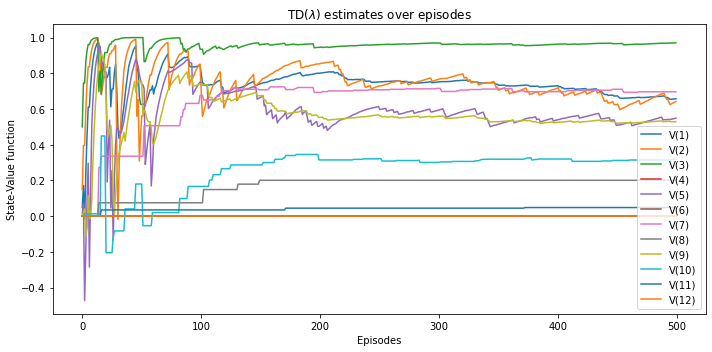

In [89]:
plt.figure(figsize=(10,5))
legends = ['V(1)','V(2)','V(3)','V(4)','V(5)','V(6)','V(7)','V(8)','V(9)','V(10)','V(11)','V(12)']
plt.plot(V_ntd_track)
plt.title('TD($\lambda$) estimates over episodes')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()